Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import datetime, time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import scale, LabelEncoder

from scipy.stats import ranksums

Function Definitions

In [20]:
# SMOTE: Overclassing Minority Classification
def Oversample(dataset, X_train, y_train):

    print('Total Data', len(y_train))
    print('Imbalance: [-]', sum(y_train==0), '[+]', sum(y_train==1))

    print("\nPerforming SMOTE on training data set\n")
    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

    print('Total Data', len(y_train_res))
    print('Imbalance: [-]', sum(y_train_res==0), '[+]', sum(y_train_res==1))
    
    return (X_train_res, y_train_res)

In [21]:
def imputate(dataset):
    imp = SimpleImputer(missing_values=np.nan, strategy='mean').fit(dataset)
    
    num_dataset = pd.DataFrame(imp.transform(dataset))
    num_dataset.columns = dataset.columns
    num_dataset.index = dataset.index

    return num_dataset

In [22]:
# For selecting the best model for train set by simple launching the several classic models
def plot_roc_curves(df_train_, X_train, X_test, y_train, y_test):
    
    # Make sure we have dropped target column
    feature_importance = pd.DataFrame(index = df_train_.columns.drop('TARGET'))

    # Plot config
    plt.figure(figsize = (7, 7))
    plt.plot([0, 1], [0, 1], 'k--')

    # LGBM Classifier
    estimator = LGBMClassifier(random_state = 0)
    estimator.fit(X_train, y_train)
    
    y_pred_xgb = estimator.predict_proba(X_test)[:, 1]
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
    
    feature_importance['LGBM'] = pd.Series(estimator.feature_importances_, index = X_train.columns)
    
    roc_score_xgb = roc_auc_score(y_test, y_pred_xgb)
    plt.plot(fpr_xgb, tpr_xgb, label = 'LGBM: ' + str(roc_score_xgb))
    
    X_train.fillna(X_train.mean(axis = 0), inplace = True)
    X_test.fillna(X_test.mean(axis = 0), inplace = True)
        
    # Random Forest Classifier
    estimator = RandomForestClassifier(random_state = 0)
    estimator.fit(X_train, y_train)
    
    y_pred_rf = estimator.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
    
    feature_importance['RF'] = estimator.feature_importances_
    
    roc_score_rf = roc_auc_score(y_test, y_pred_rf)
    plt.plot(fpr_rf, tpr_rf, label = 'RF: ' + str(roc_score_rf))
    
    
    # Logistic Regression Classifier
    estimator = LogisticRegression(random_state = 0)
    estimator.fit(X_train, y_train)
    
    y_pred_lrg = estimator.predict_proba(X_test)[:, 1]
    fpr_lrg, tpr_lrg, _ = roc_curve(y_test, y_pred_lrg)
    
    roc_score_lrg = roc_auc_score(y_test, y_pred_lrg)
    plt.plot(fpr_lrg, tpr_lrg, label = 'LogR: ' + str(roc_score_lrg))
    
    X_train = pd.DataFrame(scale(X_train), index = X_train.index, columns = X_train.columns)
    X_test = pd.DataFrame(scale(X_test), index = X_test.index, columns = X_test.columns)
    
    # Drawing Plot
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc = 'best')
    
    feature_importance['mean'] = feature_importance.mean(axis = 1)
    
    return (plt, feature_importance)

In [23]:
# For visual analysis of the fearure importances
def display_feature_importances(df_feat_imp_):
    n_columns = 3
    n_rows = (df_feat_imp_.shape[1] + 1) // n_columns
    _, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 8 * n_rows))
    for i, c in enumerate(df_feat_imp_.columns):
        sns.barplot(x = c, y = 'index', 
                    data = df_feat_imp_.reset_index().sort_values(c, ascending = False).head(20), 
                    ax = axes[i // n_columns, i % n_columns] if n_rows > 1 else axes[i % n_columns])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    
    return plt

Tasks

In [24]:
df_full = pd.read_csv("full.csv").iloc[:, 1:]
df_full.drop('SK_ID_CURR', axis=1)

df_select = df_full[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'EXT_SOURCE_3', 
            'DAYS_EMPLOYED', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN',
              'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_CAR_N']]

#train_index = df_all[df_all['TARGET'].notnull()].index
#test_index = df_all[df_all['TARGET'].isnull()].index

df_select.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,DAYS_EMPLOYED,AMT_CREDIT,AMT_ANNUITY,AMT_INCOME_TOTAL,CNT_CHILDREN,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_N
0,1.0,0.083037,0.262949,-9461.0,0.139376,-637.0,406597.5,24700.5,202500.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.311267,0.622246,-16765.0,0.510853,-1188.0,1293502.5,35698.5,270000.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.502130,0.555912,-19046.0,0.729567,-225.0,135000.0,6750.0,67500.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.502130,0.650442,-19005.0,0.510853,-3039.0,312682.5,29686.5,135000.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.502130,0.322738,-19932.0,0.510853,-3038.0,513000.0,21865.5,121500.0,0.0,0.0,1.0,0.0,1.0


In [25]:
full_data = imputate(df_full)
select_data = imputate(df_select)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df_full.drop('TARGET', axis = 1), 
                                                  df_full['TARGET'], 
                                                  test_size = 0.2, shuffle = True, random_state = 0)

X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(df_select.drop('TARGET', axis = 1), 
                                                  df_select['TARGET'], 
                                                  test_size = 0.2, shuffle = True, random_state = 0)

In [26]:
full_data = Oversample(df_full, X_train_full, y_train_full)

Total Data 246008
Imbalance: [-] 226038 [+] 19970

Performing SMOTE on training data set

Total Data 452076
Imbalance: [-] 226038 [+] 226038


In [27]:
select_data = Oversample(df_select, X_train_select, y_train_select)

Total Data 246008
Imbalance: [-] 226038 [+] 19970

Performing SMOTE on training data set

Total Data 452076
Imbalance: [-] 226038 [+] 226038


/home/liyam/anaconda3/envs/SENG474_Project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


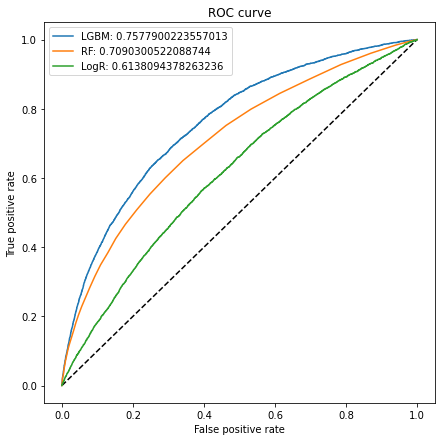

In [28]:
feature_importance_full = plot_roc_curves(df_full, X_train_full, X_test_full, y_train_full, y_test_full)
feature_importance_full[0].show()

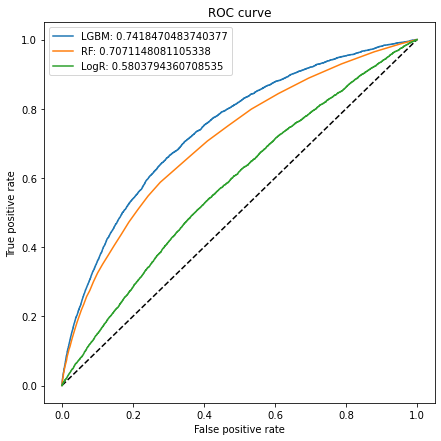

In [29]:
feature_importance_select = plot_roc_curves(df_select, X_train_select, X_test_select, y_train_select, y_test_select)
feature_importance_select[0].show()

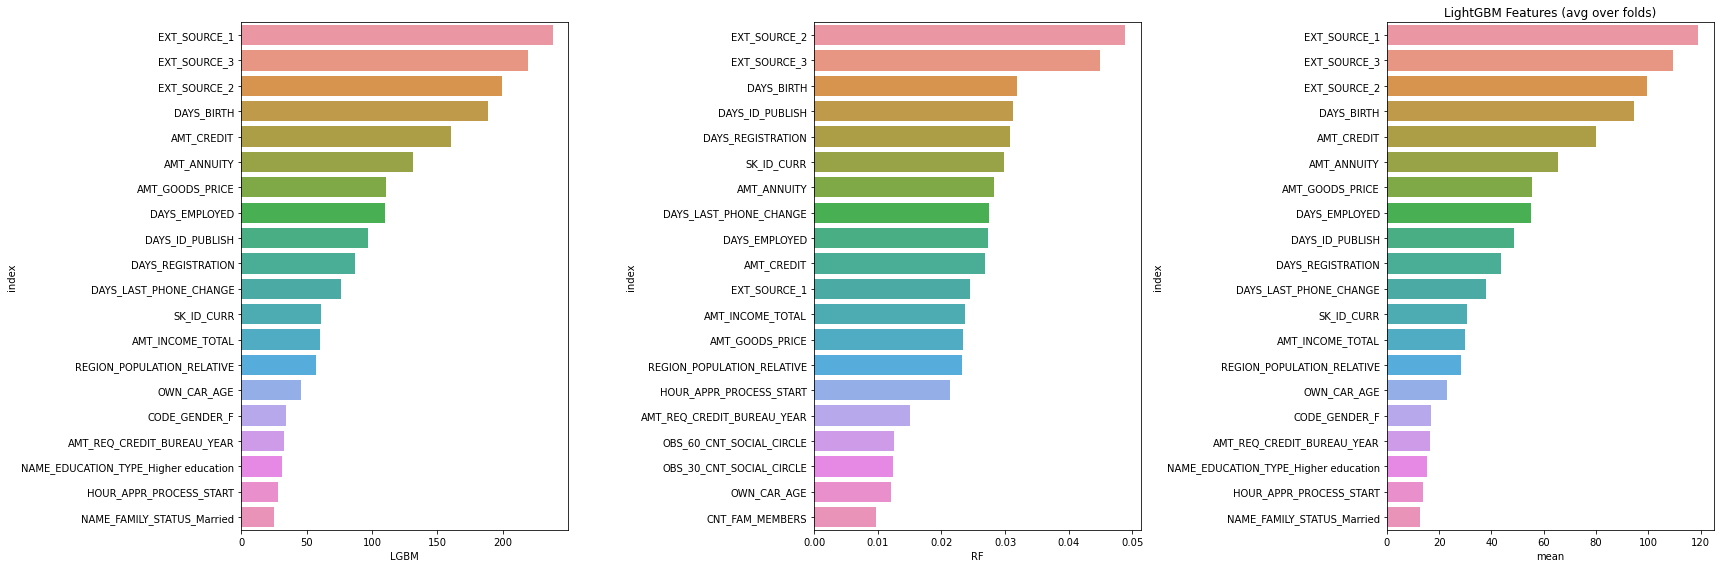

In [30]:
display_feature_importances(feature_importance_full[1]).show()

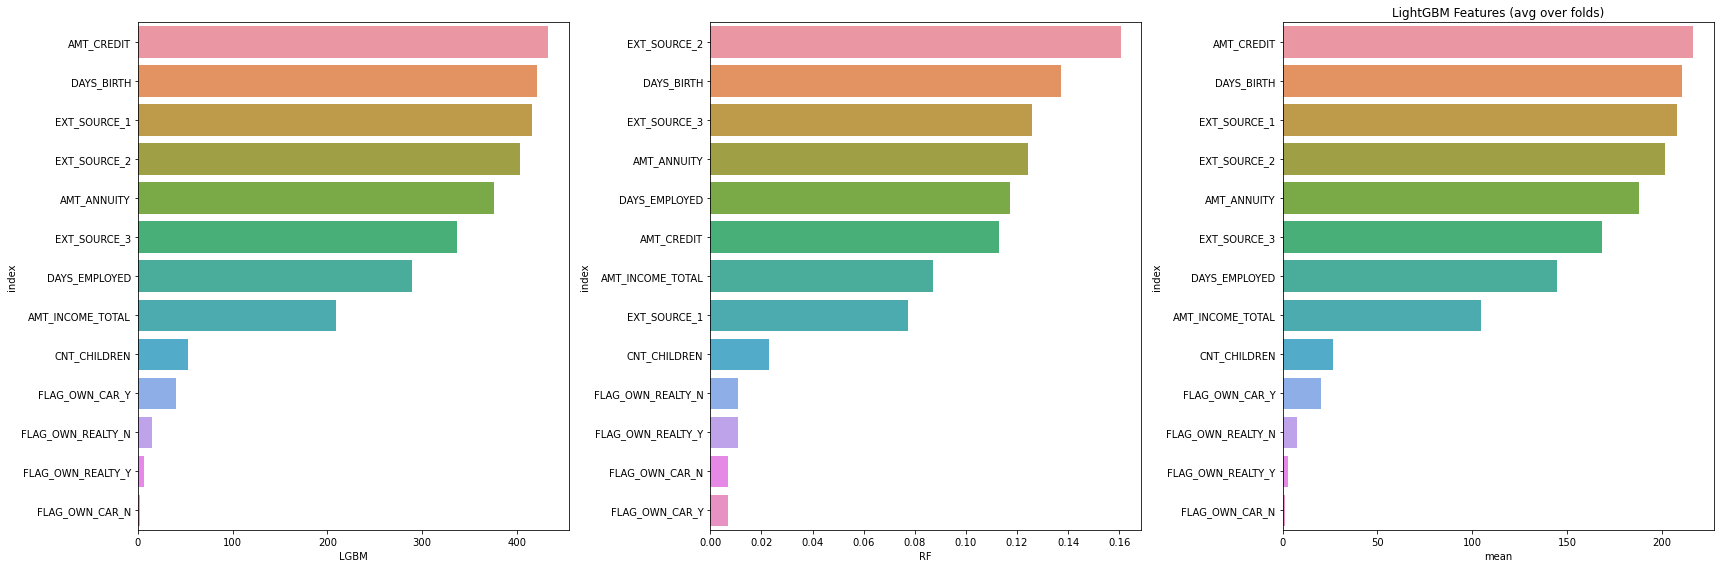

In [31]:
display_feature_importances(feature_importance_select[1]).show()